<a href="https://colab.research.google.com/github/kaiwudufe/DS-Take-Home/blob/master/colab_text_mining_ski_resort20240428.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

参考资料：<p>
Kirilenko, A. P., Wang, L., & Stepchenkova, S. O. (2022). Sentiment Analysis: Gaging Opinions of Large Groups. In R. Egger (Ed.), Applied Data Science in Tourism: Interdisciplinary Approaches, Methodologies, and Applications (pp. 363–374). Springer International Publishing. https://doi.org/10.1007/978-3-030-88389-8_17

1.出版社网址<p>    
https://doi.org/10.1007/978-3-030-88389-8   <p>
2.书籍网址<p>
http://www.datascience-in-tourism.com/   <p>
3.程序代码及数据网址（github）：<p>
https://github.com/DataScience-in-Tourism  <p>
   


数据：<br>
https://github.com/DataScience-in-Tourism 提供的示例数据只有几行，所以本例替换为kaggle上的迪尼斯乐园的数据（来自tripadvisor），程序做了相应的调整，纠正了个别错误。 <p>
    
数据下载网址 <p>
https://www.kaggle.com/datasets/arushchillar/disneyland-reviews  <br>
    
About Dataset <br>
The dataset includes 42,000 reviews of 3 Disneyland branches - Paris, California and Hong Kong, posted by visitors on Trip Advisor.
<br>
Column Description:<br>

Review_ID: unique id given to each review <br>
Rating: ranging from 1 (unsatisfied) to 5 (satisfied)<br>
Year_Month: when the reviewer visited the theme park<br>
Reviewer_Location: country of origin of visitor<br>
Review_Text: comments made by visitor<br>
Disneyland_Branch: location of Disneyland Park<br>

# 1.准备阶段

## 1.1 载入libraries

In [ ]:
# 如果运行出错，缺少那个library，就安装哪个library（通过pip或conda，可以检索一下操作方法）
# Import libraries and packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy, re

# from gensim import corpora, models, similarities, matutils
import string
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize,RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams
from nltk.corpus import stopwords, wordnet, sentiwordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import time
import emoji

# import metrics to show accuracy, recall, precision and ...
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score
from sklearn.metrics import precision_recall_fscore_support as prf_score
# from scipy.linalg import triu

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon') # vader sentiment
nltk.download('sentiwordnet') # sentiwordnet sentiment

stemmer = PorterStemmer()
sentiment_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


In [ ]:
pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 6.7 MB/s eta 0:00:00


In [ ]:
# 如果运行出错，缺少那个library，就安装哪个library（通过pip或conda，可以检索一下操作方法）
# Import libraries and packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy, re
import time



## 1.2数据快速浏览函数

In [ ]:
# data overview
def df_overview(df):
    print ('Rows     : ', df.shape[0])
    print ('Columns  : ', df.shape[1])
    print ('\nFeatures : ', df.columns.tolist())
    print ('\nMissing values :  ', df.isnull().sum().values.sum())
    print ('\nUnique values :  \n', df.nunique())
    return df.shape[0]

## 1.3文件存储目录（kaiwu）

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/kaiwu_dataset/anji_review.xlsx'

Mounted at /content/drive


## 1.4导入数据

In [ ]:

# Load the Excel file

sheet_name = 'data'

# Read the specified sheet
raw_df = pd.read_excel(file_path, sheet_name=sheet_name,engine='openpyxl')
df = raw_df.fillna("")

# Display the first few rows of the dataframe
print(df.head())

   rid ruse_type              ruser  rscore  \
0  639      实名用户             584521       5   
1  385      实名用户  _ccl43****1996647       4   
2  640      实名用户       _CFT****8631       5   
3  641      实名用户      _CFT0****4236       3   
4  642      实名用户      _CFT0****4796       5   

                                               rtext      rdate  ryear  \
0                         悬崖秋千和蹦极需要勇气，小盆友玩的卡丁车，滑草都不错 2023-09-29   2023   
1  山下停车标志不清楚，原本的景区停车场在维修，临时停车场没有工作人员引导。景区内景色优美，部分... 2023-06-24   2023   
2                                 赞 完美 天空作美 仙境传说中的一天 2023-08-19   2023   
3  景区下的免费停车，保安都用电瓶车堵住说是他们工作人员停的，我们离开没一会都是有游客来停了(我... 2023-08-08   2023   
4                       环境优美，非常好，玩的地方也很多，很刺激，记得推介！！， 2023-09-03   2023   

   rmonth  rweek  rweekday  rday rsource rsource_type  
0       9     39         5    29      浙江           省内  
1       6     25         6    24      上海           省外  
2       8     33         6    19      浙江           省内  
3       8     32         2     8      浙江        

In [ ]:
df.dtypes

rid                      int64
ruse_type               object
ruser                   object
rscore                   int64
rtext                   object
rdate           datetime64[ns]
ryear                    int64
rmonth                   int64
rweek                    int64
rweekday                 int64
rday                     int64
rsource                 object
rsource_type            object
dtype: object

In [ ]:
#显示所有行，所有列
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## 1.5筛选出2023年数据

In [ ]:
# 查看评论年份的频数
df['ryear'].value_counts()[df.ryear.unique()]

ryear
2023    2745
2024     199
Name: count, dtype: int64

In [ ]:
# 提取2023年数据
df2023=  df[df['ryear'] == 2023]
df2023.shape

(2745, 13)

## 1.6初步清洗文本

这个数据清洗步骤运行比较耗费时间<p>
      需要2397.279153585434  秒<p>


In [ ]:

# import time

# record start time
# start = time.time()


# df2023["rtext_clean"] = df2023["rtext"].apply(lambda x: clean_text(x))
# df2023.head(5)

# record end time
# end = time.time()

# print the difference between start
# and end time in milli. secs
# print("The time of execution of above program is :",
#      (end-start) , "s")

The time of execution of above program is : 2397.279153585434 s


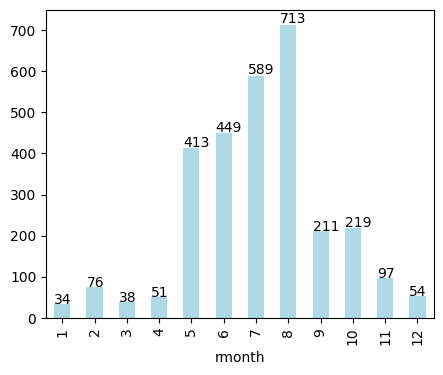

In [ ]:

plot1=df["rmonth"].value_counts().sort_index().plot(kind="bar",figsize=(5,4),color="lightblue")
for p in plot1.patches:
    plot1.annotate(str(p.get_height()), (p.get_x() , p.get_height() * 1.005))

## 1.7保存数据

In [ ]:
#df2023.to_excel(datafolder+'anji_review2023.xlsx')

In [ ]:
#df2023.reset_index(inplace = True)
#df2023.to_feather(datafolder+'anji_review2023.feather')

In [ ]:
df2023.dtypes

rid                      int64
ruse_type               object
ruser                   object
rscore                   int64
rtext                   object
rdate           datetime64[ns]
ryear                    int64
rmonth                   int64
rweek                    int64
rweekday                 int64
rday                     int64
rsource                 object
rsource_type            object
dtype: object

# 2.主题建模分析topic modeling


## 2.1 load libraries

In [ ]:
import jieba
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from gensim import corpora, models

## 2.2 加载数据

In [ ]:
df2023=pd.read_feather('/content/drive/My Drive/kaiwu_dataset/anji_review2023.feather')

In [ ]:
df2023.head(3)

,index,rid,ruse_type,ruser,rscore,rtext,rdate,ryear,rmonth,rweek,rweekday,rday,rsource,rsource_type
0,0,639,实名用户,584521,5,悬崖秋千和蹦极需要勇气，小盆友玩的卡丁车，滑草都不错,2023-09-29,2023,9,39,5,29,浙江,省内
1,1,385,实名用户,_ccl43****1996647,4,山下停车标志不清楚，原本的景区停车场在维修，临时停车场没有工作人员引导。景区内景色优美，部分...,2023-06-24,2023,6,25,6,24,上海,省外
2,2,640,实名用户,_CFT****8631,5,赞 完美 天空作美 仙境传说中的一天,2023-08-19,2023,8,33,6,19,浙江,省内


## 2.3 导入停词表 Load Stop Words

In [ ]:
with open('/content/drive/My Drive/kaiwu_dataset/stopwords_cn.txt', 'r', encoding='utf-8') as file:  # Ensure correct encoding
    stop_words = set(file.read().strip().splitlines())

## 2.4 jieba与停词表配合使用

In [ ]:
def segment_filter(text, stop_words):
    words = jieba.cut(text)
    filtered_words = ' '.join(word for word in words if word not in stop_words)
    return filtered_words

df2023['segmented_text'] = df2023['rtext'].apply(lambda x: segment_filter(x, stop_words))

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.633 seconds.
DEBUG:jieba:Loading model cost 1.633 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


## 2.5 生成 文档-词项矩阵（Document-Term Matrix）

Use CountVectorizer to convert the segmented text data into a document-term matrix, which can then be used for topic modeling:

In [ ]:
vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(df2023['segmented_text'])


## 2.6 执行主题建模 Topic Modeling

这里选了5个主题，可以改为8，10个

In [ ]:
lda = LatentDirichletAllocation(n_components=5, random_state=0)  # Change parameters as needed
lda.fit(dtm)

LatentDirichletAllocation(n_components=5, random_state=0)

In [ ]:
def print_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

print_topics(lda, vectorizer.get_feature_names_out(), 10)

Topic #0:
值得 项目 冬天 滑雪 一去 秋千 体验 刺激 好棒 缭绕
Topic #1:
风景 不错 草原 景色 云上 孩子 项目 好玩 真的 天空
Topic #2:
排队 小时 项目 缆车 体验 不错 索道 山上 上山 适合
Topic #3:
云上 草原 项目 风景 推荐 风景优美 好玩 不错 游玩 开心
Topic #4:
好玩 项目 刺激 特别 下次 景区 风景 悬崖 值得 服务


## 2.7 数据可视化data visualization

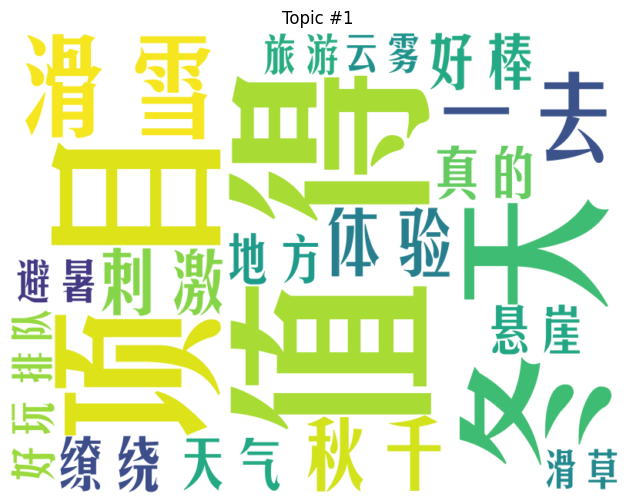

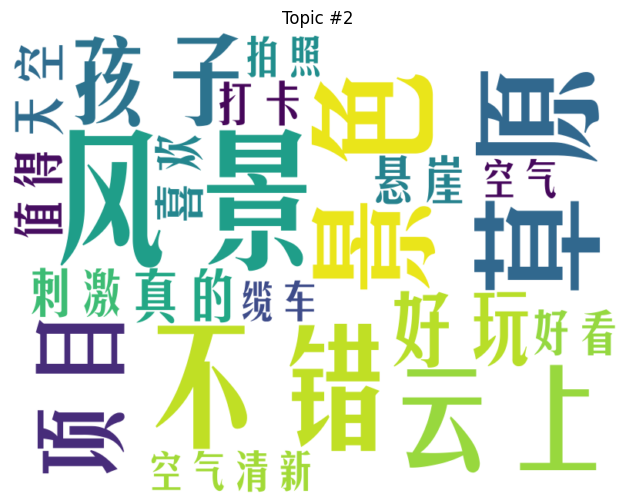

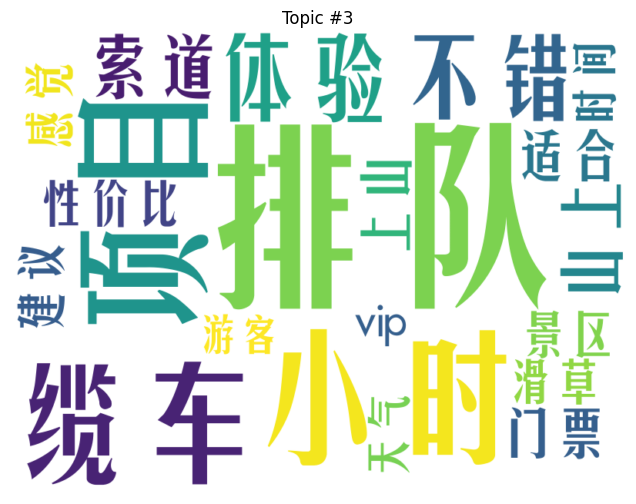

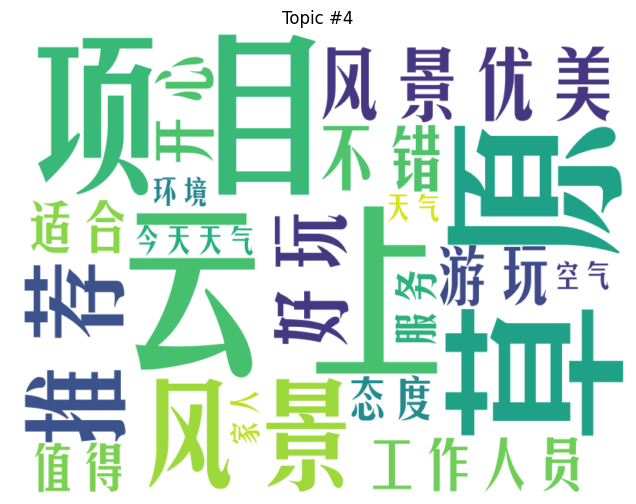

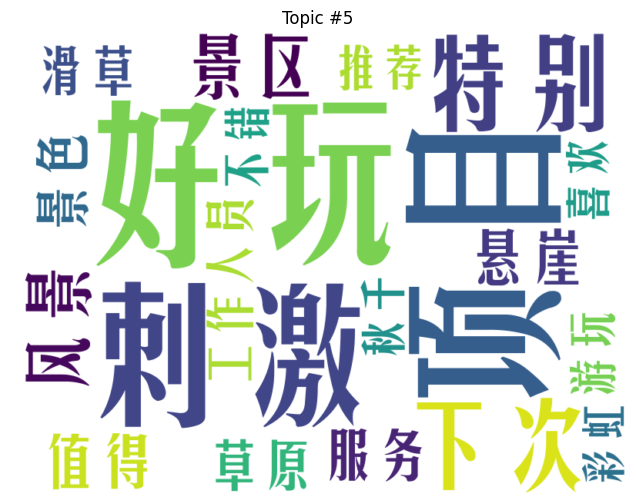

In [ ]:
def plot_word_clouds(model, feature_names, n_words):
    for topic_idx, topic in enumerate(model.components_):
        plt.figure(figsize=(8, 6))
        topic_word_probs = {feature_names[i]: topic[i] for i in topic.argsort()[:-n_words - 1:-1]}
        wordcloud = WordCloud(font_path='/content/drive/My Drive/kaiwu_dataset/font.ttf',width=800, height=600, background_color='white').generate_from_frequencies(topic_word_probs)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f'Topic #{topic_idx + 1}')
        plt.show()

plot_word_clouds(lda, vectorizer.get_feature_names_out(), 20)

<ipython-input-57-02af38b8b904>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='hsv')


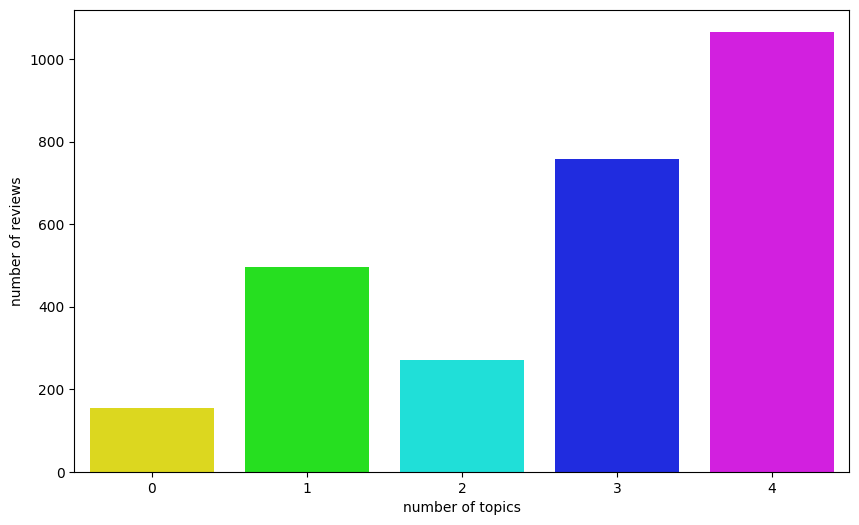

In [ ]:
# from matplotlib.font_manager import FontProperties

# uploaded_font_path = '/content/drive/My Drive/kaiwu_dataset/font.ttf'  # Adjust the path to your uploaded font file

# Load and use the uploaded font
# prop = FontProperties(fname=uploaded_font_path)
# plt.rcParams['font.family'] = prop.get_name()
# plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
# 获得每个评论的主导性主题 Get dominant topic for each document
dominant_topic = np.argmax(lda.transform(dtm), axis=1)
df2023['dominant_topic'] = dominant_topic

# 统计各主题对应的评论数 Count number of documents per topic
topic_counts = df2023['dominant_topic'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='hsv')
plt.xlabel('number of topics')
plt.ylabel('number of reviews')
plt.title('')
plt.show()

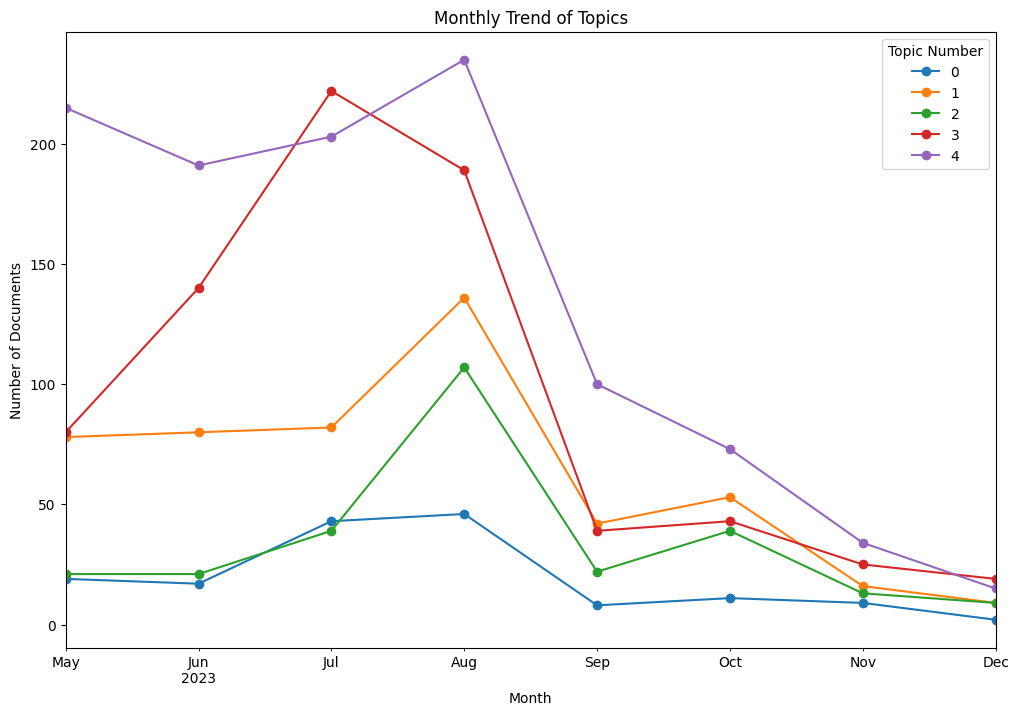

In [ ]:
# rdate是评论时间
df2023.set_index('rdate', inplace=True)

# 计算每个月的主题分布
monthly_topic_distribution = df2023.groupby('dominant_topic').resample('M').size().unstack(0)

# Plot
monthly_topic_distribution.plot(kind='line', figsize=(12, 8), marker='o')
plt.title('Monthly Trend of Topics')
plt.xlabel('Month')
plt.ylabel('Number of Documents')
plt.legend(title='Topic Number')
plt.show()

## 2.8数据分析结果保存

In [ ]:

df2023.to_excel('/content/drive/My Drive/kaiwu_dataset/anji_review2023with_topics.xlsx')


In [ ]:
df2023.reset_index(inplace=True)

df2023.to_feather('/content/drive/My Drive/kaiwu_dataset/anji_review2023with_topics.feather')


In [ ]:
df2023.dtypes

level_0                    int64
rdate             datetime64[ns]
index                      int64
rid                        int64
ruse_type                 object
ruser                     object
rscore                     int64
rtext                     object
ryear                      int64
rmonth                     int64
rweek                      int64
rweekday                   int64
rday                       int64
rsource                   object
rsource_type              object
segmented_text            object
tokens                    object
dominant_topic             int64
dtype: object

# 3.主题建模：分组比较

## 3.1 拆分数据：省内vs.省外

First, separate your dataset into two groups based on the rsource_type:

In [ ]:
group1 = df2023[df2023['rsource_type'] == '省内']
group2 = df2023[df2023['rsource_type'] == '省外']

## 3.2 两组数据分别进行主题建模Perform Topic Modeling Separately

You'll apply topic modeling to each group separately. This way, you can understand how the topics differ between them.

In [ ]:
# Apply preprocessing and vectorization for each group


vectorizer1 = CountVectorizer()
dtm1 = vectorizer1.fit_transform(group1['segmented_text'])

vectorizer2 = CountVectorizer()
dtm2 = vectorizer2.fit_transform(group2['segmented_text'])



# Topic Modeling for each group
lda1 = LatentDirichletAllocation(n_components=5, random_state=0)
lda1.fit(dtm1)

lda2 = LatentDirichletAllocation(n_components=5, random_state=0)
lda2.fit(dtm2)


LatentDirichletAllocation(n_components=5, random_state=0)

## 3.3比较主题关键词 Compare Topic Keywords

In [ ]:
def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx + 1}:")
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

print("Topics from Option1:")
print_topics(lda1, vectorizer1, 10)

print("\nTopics from Option2:")
print_topics(lda2, vectorizer2, 10)

Topics from Option1:
Topic #1:
草原 云上 项目 好玩 风景 推荐 不错 值得 风景优美 游玩
Topic #2:
好玩 项目 刺激 下次 风景 景区 工作人员 服务 特别 悬崖
Topic #3:
项目 排队 山上 体验 滑草 缆车 秋千 玻璃 风景 上山
Topic #4:
不错 工作人员 项目 景色 天气 开心 风景 孩子 性价比 很漂亮
Topic #5:
值得 真的 适合 索道 风景 云海 天空 景区 喜欢 小时

Topics from Option2:
Topic #1:
项目 草原 云上 排队 索道 刺激 小时 景区 好玩 山上
Topic #2:
排队 缆车 项目 滑草 风景 好玩 服务 vip 真的 小时
Topic #3:
项目 不错 好玩 适合 风景 景色 索道 山上 推荐 刺激
Topic #4:
项目 刺激 好玩 喜欢 风景 不错 孩子 小朋友 山上 体验
Topic #5:
值得 地方 开心 草原 一去 云上 好玩 景区 风景 下次


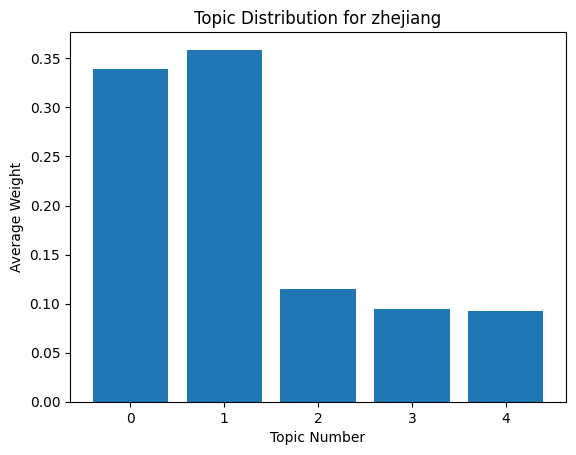

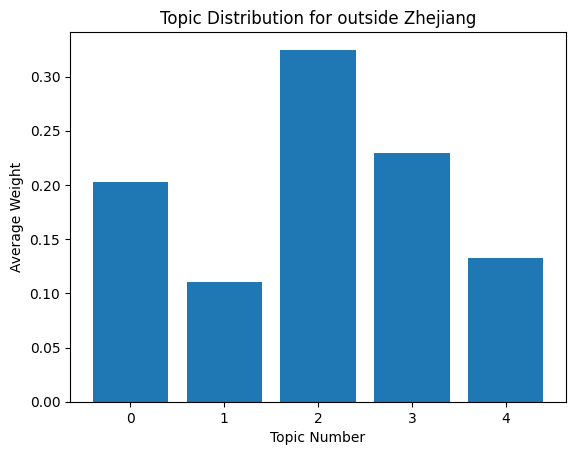

In [ ]:
# Function to plot topic distribution for each group
def plot_topic_distribution(lda, dtm, title):
    topic_weights = np.array(lda.transform(dtm))
    topic_distribution = topic_weights.mean(axis=0)
    plt.bar(range(len(topic_distribution)), topic_distribution)
    plt.title(title)
    plt.xlabel('Topic Number')
    plt.ylabel('Average Weight')
    plt.show()

plot_topic_distribution(lda1, dtm1, 'Topic Distribution for zhejiang')
plot_topic_distribution(lda2, dtm2, 'Topic Distribution for outside Zhejiang')

## 3.4统计上的比较分析

In [ ]:
from scipy.stats import chi2_contingency

# Aggregate topic occurrences
topic_counts1 = np.argmax(lda1.transform(dtm1), axis=1)
topic_counts2 = np.argmax(lda2.transform(dtm2), axis=1)
contingency_table = np.array([np.bincount(topic_counts1, minlength=5),
                              np.bincount(topic_counts2, minlength=5)])

chi2, p, dof, ex = chi2_contingency(contingency_table)
print(f"Chi-square test result: p-value = {p}")

Chi-square test result: p-value = 7.750151362403112e-114


## 3.5 保存结果

In [ ]:
def get_topic_distribution(lda, dtm):
    topic_weights = np.array(lda.transform(dtm))
    topic_distribution = topic_weights.mean(axis=0)
    return topic_distribution

# Get distributions
distribution1 = get_topic_distribution(lda1, dtm1)
distribution2 = get_topic_distribution(lda2, dtm2)

In [ ]:
df_distribution1 = pd.DataFrame({'Topic Number': range(1, len(distribution1) + 1),
                                 'Average Weight': distribution1},
                                columns=['Topic Number', 'Average Weight'])

df_distribution2 = pd.DataFrame({'Topic Number': range(1, len(distribution2) + 1),
                                 'Average Weight': distribution2},
                                columns=['Topic Number', 'Average Weight'])

In [ ]:

df_distribution1.to_excel('/content/drive/My Drive/kaiwu_dataset/Topic_Distribution_zhejiang.xlsx', index=False)
df_distribution2.to_excel('/content/drive/My Drive/kaiwu_dataset/Topic_Distribution_outside.xlsx', index=False)